# Market Timing

Market Timing is often considered a strategy for beating the markets and making profits. We would try to explore whether market timing actually works. We would work with the NIFTY index.

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

In [15]:
# Load your data here
filename = '/home/machine/Downloads/NIFTY 50_Data.csv'
df = pd.read_csv(filename, parse_dates=['Date'])
df.rename(lambda x: x.lower(), axis='columns', inplace=True)
df = df.set_index('date').sort_index()

## Dollar averaging method

Dollar averaging is one of the most popular methods used in investment. Under this method, we would buying a stock or an index fund at periodic intervals irrespective of trend. The underlying assumption is equity markets are profitable in the long run and investing them over periodic intervals for a long period of time would lead to the benefits of compounding.


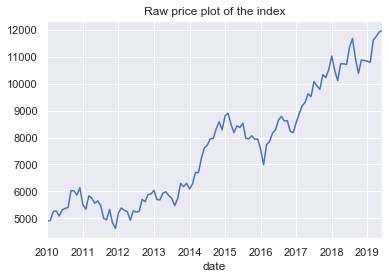

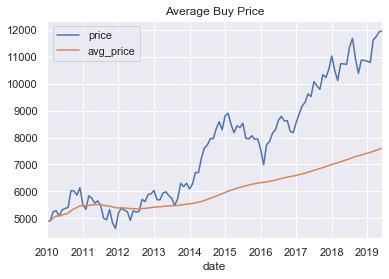

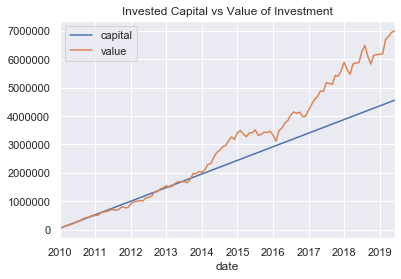

In [48]:
# Buy index at the close price of each month; assume integer quantities
freq = 'M' # buy every month - W for week; 2W for every 2 weeks
capital = 40000 # investment every period
df2 = df.resample(freq).close.last().reset_index()
df2.columns = ['date', 'price']
df2['avg_price'] = df2.price.expanding().mean()
df2['capital'] = capital * (df2.index+1)
df2['qty'] = (capital/df2['price']).astype(int)
df2['value'] = df2.qty.cumsum() * df2.price
df2.set_index('date').price.plot(title='Raw price plot of the index')
df2.set_index('date')[['price', 'avg_price']].plot(title='Average Buy Price')
df2.set_index('date')[['capital', 'value']].plot(
    title='Invested Capital vs Value of Investment')

So ,it took 4 years before your investment start getting returns on your capital.

You would be in for a surprise if you change the frequency to weekly **W**.

Hint `(capital/df2['price']).astype(int)`

## Moving average crossover

One of the most suggested strategies is the moving average crossover where you buy when one moving average crosses another. Let's implement a long only strategy implementing MA crossover.

1. Select two periods ma1, ma2 so that ma1 > ma2
2. Calculate the simple moving average for the 2 periods
3. BUY when ma1 > ma2
4. SELL when ma1 < ma2; hold as long as ma1 > ma2
5. Enter into a new position only when there are no open positions

In [114]:
from fastbt.tradebook import TradeBook

capital = 100000
ma1 = 15
ma2 = 30
df2 = df.copy()
df2['ma1'] = df2.rolling(ma1).close.mean()
df2['ma2'] = df2.rolling(ma2).close.mean()

tb = TradeBook()
for date,row in df2.dropna().iterrows():
    # Enter into a position only when there are no open positions
    if tb.o == 0:
        if row['ma1'] > row['ma2']:
            qty = int(capital/row['close'])
            tb.add_trade(date, 'NIFTY', row['close'], qty, order='B',
                        ma1=row['ma1'], ma2=row['ma2'])
    # Exit in case of an open order
    if tb.o > 0:
        last_qty = abs(tb.trades['NIFTY'][-1]['qty'])
        if row['ma1'] < row ['ma2']:
            tb.add_trade(date, 'NIFTY', row['close'], last_qty, order='S',
                        ma1=row['ma1'], ma2=row['ma2'])
            
# Close any existing position at the end of the period
if tb.o > 0:
    last_qty = abs(tb.trades['NIFTY'][-1]['qty'])
    tb.add_trade(date, 'NIFTY', row['close'], last_qty, order='S',
                 ma1=row['ma1'], ma2=row['ma2'])

# In case of investment left untouched
return_per_qty = df2.close.iloc[-1] - df2.close.iloc[0]  
start_qty = int(capital/df2.close.iloc[0])
total_return = return_per_qty * start_qty
returns_calc = lambda x,y : (x/y)*100

print('Returns when invested and left alone\nAmount={:.0f}; \
Returns={:.2f}%'.format(total_return, returns_calc(total_return, capital)))
print('Returns from the strategy\nAmount={:.0f};Returns={:.2f}%'.format(
    tb.values['NIFTY'], returns_calc(tb.values['NIFTY'], capital)))

Returns when invested and left alone
Amount=127935; Returns=127.93%
Returns from the strategy
Amount=26554;Returns=26.55%
